## Задание  
Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO  
Библиотеки: [Python, Tensorflow]

In [1]:
import os
import sys
import random

import numpy as np

import matplotlib.pyplot as plt
import imageio
import skimage.io as io

import tensorflow as tf

## Загрузка датасета COCO и COCO API

In [2]:
if 0:
    !mkdir -p data

    # !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    # !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    # !cd data && unzip -q train2017.zip
    # !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

In [3]:
from pycocotools.coco import COCO

In [4]:
COCO_ROOT = './data/'
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))

## Универсальный класс Dataset для сегментации

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist, img_count=None):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = random.choices(self.coco.getImgIds(catIds=self.cat_ids),
                                       k=img_count) if img_count else self.coco.getImgIds(catIds=self.cat_ids)

    
    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [7]:
INPUT_SIZE = 256
BATCH_SIZE = 16
NUM_EPOCHS = 3

In [8]:
COCO_dataset_train = COCO_Dataset('train', 8000)
COCO_dataset_val = COCO_Dataset('val', 1000)

loading annotations into memory...
Done (t=17.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


In [9]:
len(COCO_dataset_train.img_list)

8000

In [10]:
len(COCO_dataset_val.img_list)

1000

In [11]:
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE,
                                            epochs=NUM_EPOCHS,
                                            inp_size=INPUT_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE,
                                      inp_size=INPUT_SIZE)

## Отображение случайного батча изображений и карт сегментации

In [22]:
def get_random_batch(ds):
    rand_batch_num = random.randint(0, len(ds)-1)
    sample_batch = iter(ds.skip(rand_batch_num).take(1)).get_next()
    return sample_batch

In [23]:
def show_batch_images(sample_batch):
    plt.figure(figsize=(15, 30))
    for i in range(BATCH_SIZE):
        for j in range(2):
            ax = plt.subplot(BATCH_SIZE//2, 4, 2*i+j+1)
            ax.imshow(sample_batch[j][i,:,:,:], cmap='gray' if j else 'viridis')
            plt.xticks([]), plt.yticks([])
    plt.show()

In [24]:
def show_batch_images_with_mask(sample_batch):
    plt.figure(figsize=(15, 15))
    for i in range(BATCH_SIZE):
        seg_map = (sample_batch[1][i,:,:,0]>0.5).numpy().astype(np.float32)
        seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]

        ax = plt.subplot(BATCH_SIZE//4, 4, i+1)
        ax.imshow(sample_batch[0][i,:,:,:]*0.5 + seg_map_clr*0.5)
        plt.xticks([]), plt.yticks([])
    plt.show()

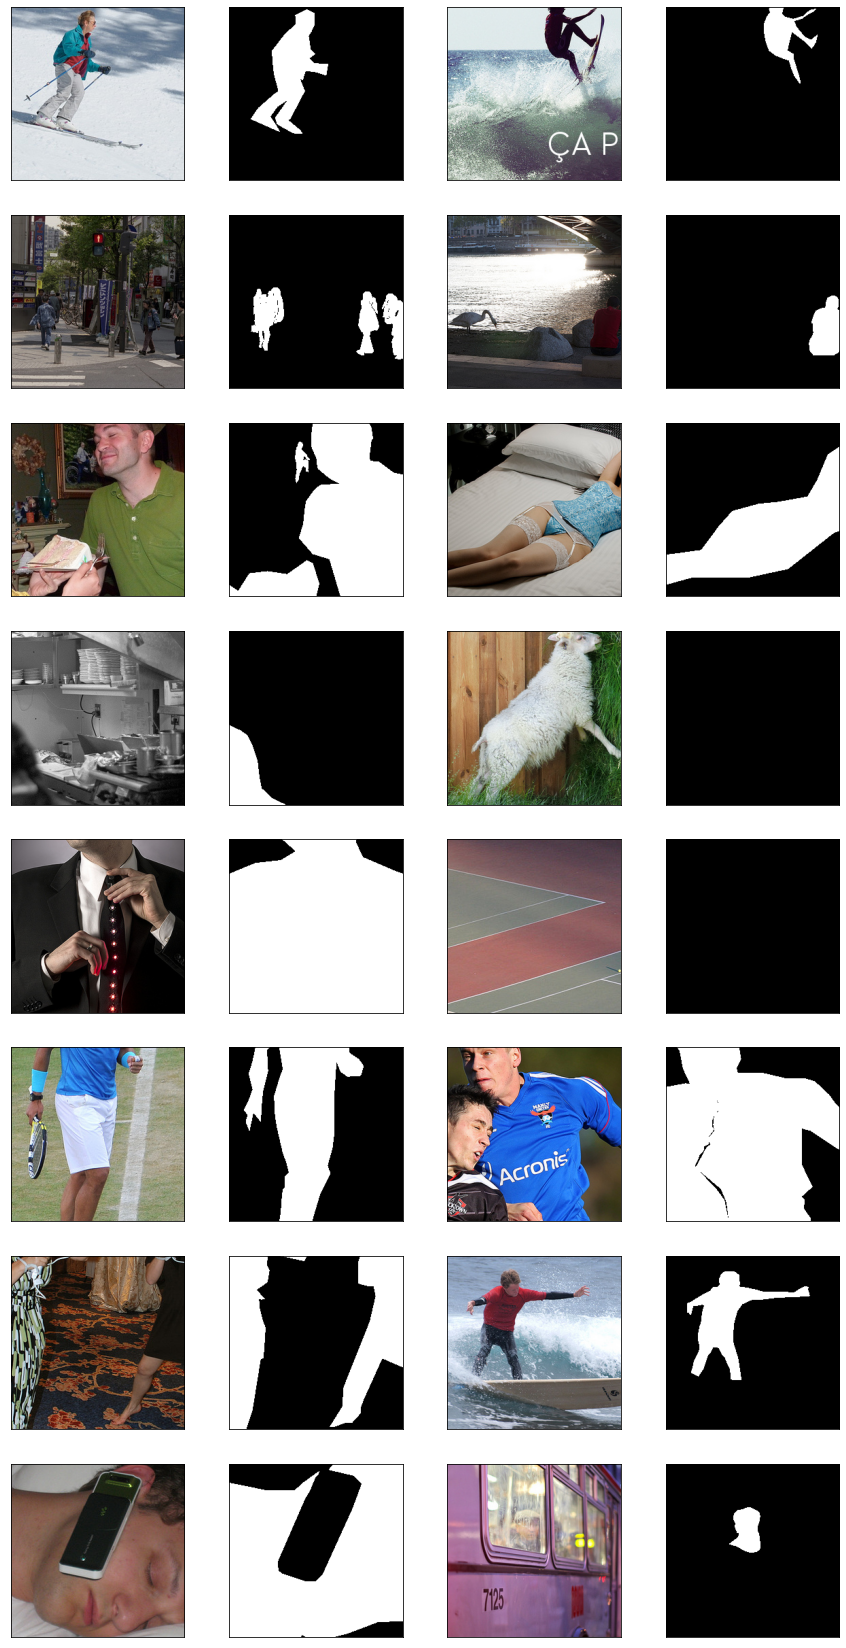

In [25]:
sample_batch = get_random_batch(val_ds)
show_batch_images(sample_batch)

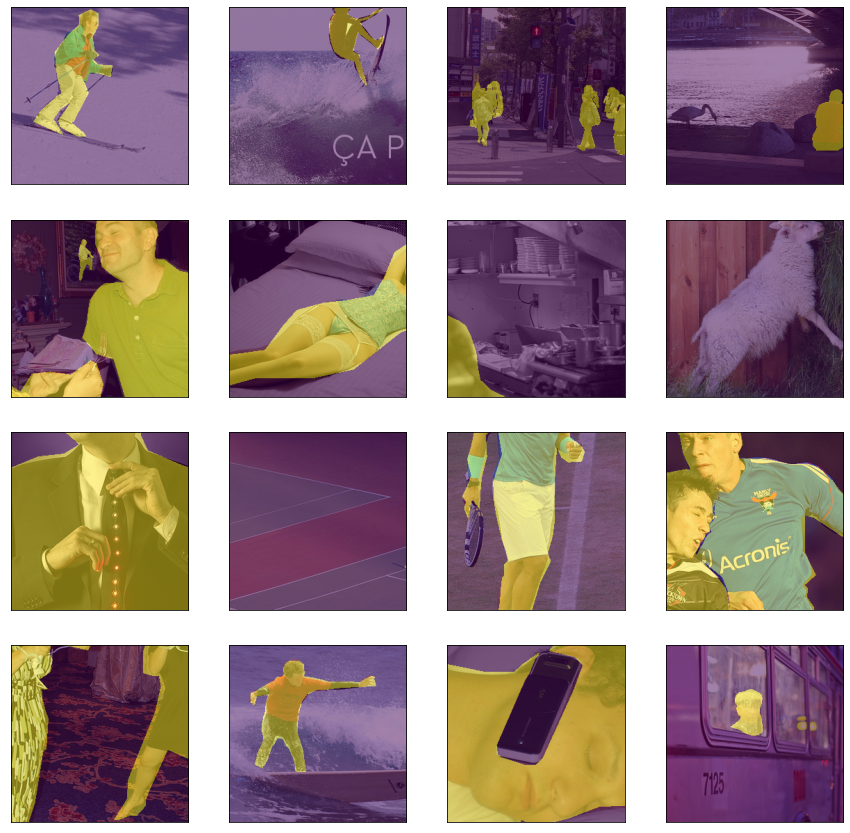

In [26]:
show_batch_images_with_mask(sample_batch)

## Модель ASPP

In [16]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

In [17]:
model_ASPP = ASPPNet()

## Обучение модели

In [18]:
loss = tf.keras.losses.BinaryCrossentropy()

In [19]:
model_ASPP.build(input_shape=(None, INPUT_SIZE, INPUT_SIZE, 3))
model_ASPP.compile(optimizer='adam', loss=loss)

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', 
    write_graph=False, update_freq=100, profile_batch=0)

In [21]:
history = model_ASPP.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=val_ds,
    callbacks=[tensorboard_callback])

Epoch 1/3
1500/1500 [==============================] - 40570s 27s/step - loss: 0.4706 - val_loss: 0.4400
Epoch 2/3
1500/1500 [==============================] - 37166s 25s/step - loss: 0.3805 - val_loss: 0.3931
Epoch 3/3
1500/1500 [==============================] - 41113s 27s/step - loss: 0.3388 - val_loss: 0.3714


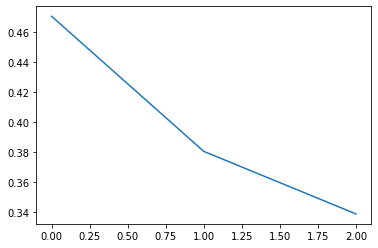

In [33]:
plt.plot(history.history['loss'])

In [36]:
model_ASPP.save('./model_ASPP_COCO')

INFO:tensorflow:Assets written to: ./model_ASPP_COCO\assets


INFO:tensorflow:Assets written to: ./model_ASPP_COCO\assets


## Инференс для случайного изображения

In [27]:
sample_batch = get_random_batch(val_ds)

In [28]:
def get_random_image(sample_batch):
    rand_idx = random.randint(0, BATCH_SIZE-1)
    img = sample_batch[0][rand_idx]
    mask = sample_batch[1][rand_idx]
    
    fig = plt.figure(figsize=(10,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(img)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(mask, cmap='gray')
    
    return img, mask

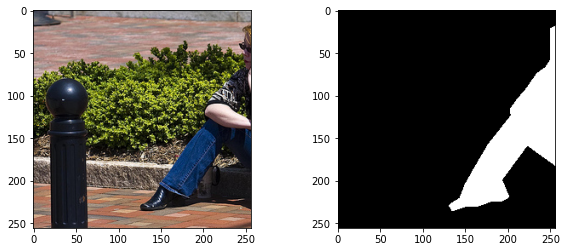

In [29]:
img, mask = get_random_image(sample_batch)

1/1 [==============================] - 1s 952ms/step


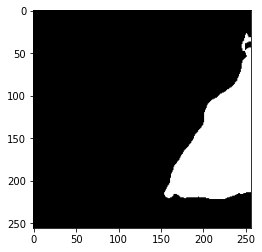

In [30]:
out = model_ASPP.predict(img[None, ...])[0, ...]
out_seg_map = (out[..., 0]>0.5).astype(np.float32)

_= plt.imshow(out_seg_map, cmap='gray')

## Наложение карты сегментации на изображение

In [31]:
def show_img_with_mask(img, seg_map):
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    plt.imshow(img*0.5 + seg_map_clr*0.5)
    plt.show()

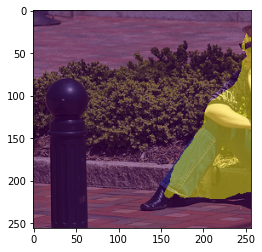

In [32]:
show_img_with_mask(img, out_seg_map)